In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain.agents import Tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver


/home/luecha-kanm/Documents/Dev/Agintic-AI/agentic_ai_engineer_course/4_langgraph/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass4.getpass("Enter your Google AI API key: ")

In [3]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

## Asynchronous LangGraph

### To run a tool:
- **Sync:** `tool.run(inputs)`
- **Async:** `await tool.arun(inputs)`

### To invoke the graph:
- **Sync:** `graph.invoke(state)`
- **Async:** `await graph.ainvoke(state)`


In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

In [5]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()

tool_search = Tool(
    name="search",
    description="Useful for when you need more information from an online search",
    func=serper.run,
)

In [6]:
def calculate_math(expression: str) -> str:
    """Calculate mathematical expressions safely"""
    try:
        # Remove any potentially dangerous characters and evaluate safely
        allowed_chars: set[str] = set("0123456789+-*/(). ")
        if all(c in allowed_chars for c in expression):
            result = eval(expression)
            return f"ผลลัพธ์: {expression} = {result}"
        else:
            return "ข้อผิดพลาด: นิพจน์ไม่ถูกต้อง ใช้ได้เฉพาะตัวเลขและเครื่องหมาย +, -, *, /, (, ) เท่านั้น"
    except Exception as e:
        return f"ข้อผิดพลาดในการคำนวณ: {str(e)}"


calculate_tool = Tool(
    name="calculator",
    func=calculate_math,
    description="Use this to calculate mathematical expressions. Input should be a valid math expression like '2 + 3 * 4' or '(10 + 5) / 3'",
)

calculate_tool.invoke("1+2")

'ผลลัพธ์: 1+2 = 3'

## Next: Install Playwright

### On Windows and MacOS:
```bash
playwright install
```

### On Linux:
```bash
playwright install --with-deps chromium
```

Introducing nest_asyncio

Python async code only allows for one "event loop" processing asynchronous events.

The `nest_asyncio` library patches this, and is used for special situations, if you need to run a nested event loop.

In [7]:
import nest_asyncio
nest_asyncio.apply()

### The LangChain Community

One of the remarkable things about the rich LangChain community around it.

Check this out:

In [8]:
import nest_asyncio; nest_asyncio.apply()

from playwright.async_api import async_playwright
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit

async def setup(headless=False):
    p = await async_playwright().start()
    browser = await p.chromium.launch(headless=headless)
    # ใช้ from_browser โดยระบุ async_browser
    toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=browser)
    tools = toolkit.get_tools()
    return tools, browser, p

tools, browser, p = await setup(False)

# ... ใช้งาน tools ...

# ปิดงาน
# await browser.close()
# await p.stop()


In [9]:
for tool in tools:
    print(f"{tool.name}={tool}")

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/luecha-kanm/.cache/ms-playwright/chromium-1187/chrome-linux/chrome> version=140.0.7339.16>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/luecha-kanm/.cache/ms-playwright/chromium-1187/chrome-linux/chrome> version=140.0.7339.16>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/luecha-kanm/.cache/ms-playwright/chromium-1187/chrome-linux/chrome> version=140.0.7339.16>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/luecha-kanm/.cache/ms-playwright/chromium-1187/chrome-linux/chrome> version=140.0.7339.16>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/luecha-kanm/.cache/ms-playwright/chromium-1187/chrome-linux/chrome> version=140.0.7339.16>
get_elements=async_browser=<Browser type=<BrowserType name=chromium executable_p

In [10]:
tools_dict = {tool.name: tool for tool in tools}

navigate_tool = tools_dict.get("navigate_browser")
extract_text_tool = tools_dict.get("extract_text")

await tools_dict["navigate_browser"].arun({"url": "https://cnn.com"})
text = await tools_dict["extract_text"].arun({})

# ctx = await browser.new_context(); ctx.set_default_navigation_timeout(60000)
# page = await ctx.new_page()
# await page.goto("https://www.cnn.com", wait_until="domcontentloaded")
# text = await tools_dict["extract_text"].arun({})

In [11]:
import textwrap

print(textwrap.fill(text))

Breaking News, Latest News and Videos | CNN CNN values your feedback
1. How relevant is this ad to you? 2. Did you encounter any technical
issues? No Video player was slow to load content Video content never
loaded Ad froze or did not finish loading Video content did not start
after ad Audio on ad was too loud Other issues Ad never loaded Ad
prevented/slowed the page from loading Content moved around while ad
loaded Ad was repetitive to ads I've seen previously Other issues
Cancel Submit Thank You! Your effort and contribution in providing
this feedback is much
appreciated. Close Ad Feedback Close icon US World Politics Business
Health Entertainment Style Travel Sports Science Climate Weather
Ukraine-Russia War Israel-Hamas War Games More US World Politics
Business Health Entertainment Style Travel Sports Science Climate
Weather Ukraine-Russia War Israel-Hamas War Games Watch Listen Live TV
Subscribe Sign in My Account Settings Newsletters Topics you follow
Sign out Your CNN account Si

In [ ]:
all_tools = tools + [calculate_tool]

In [13]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

llm_with_tools = llm.bind_tools(all_tools)

def chatbot(state: State) -> State:
    """This function is called when the user sends a message to the chatbot."""

    return {"messages": [llm_with_tools.invoke(state["messages"])]}

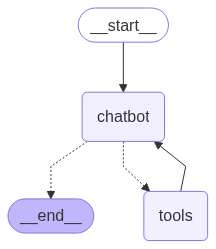

In [14]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))
graph_builder.add_conditional_edges(
    "chatbot", tools_condition, {"tools": "tools", "__end__": END}
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
config = {"configurable": {"thread_id": "222"}}

async def chat(user_input: str, history) -> str:
    """This function is called when the user sends a message to the chatbot."""
    result = await graph.ainvoke(
        {"messages": [{"role": "user", "content": user_input}]}, config=config
    )
    print(result)
    
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='34d0647b-61b6-4434-9ecd-8617fdce602d'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--daa9ae67-e618-4064-9dc3-4ceb07f978fd-0', usage_metadata={'input_tokens': 433, 'output_tokens': 9, 'total_tokens': 442, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='1c3e7b42-0469-4171-84d8-86e70d30aed0'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--a60dd9e4-82ab-4df9-ba5e-7f4cdb9d8b62-0', usage_metadata={'input_tokens': 445, 'output_tokens': 9,